# Using Neo4j Cypher

In [8]:
from neo4j import GraphDatabase
import os
from dotenv import load_dotenv

load_dotenv("./.env", override=True)

URI = os.getenv("NEO4J_URL")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [41]:
import pandas as pd

path = "./scrapped_reviews/reviews_selected_small.csv"
df = pd.read_csv(path)
df.dropna(inplace=True)
# reordering index
df.reset_index(drop=True, inplace=True)
df.head(1)

,place_name,review_text,rating,published_at_date
0,Curly Hair Designs,I ve been a client of Curly Hair Designs since...,5,12:42.3


In [10]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
import enum

class Labels(enum.Enum):
    """Labels for the topics"""
    stylist_name = "stylist_name"

    hair_cut = "hair_cut"
    single_color = "single_color"
    highlights = "highlights"
    perm = "perm"
    straightening = "straightening"
    hair_care = "hair_care"

    rude = "rude"
    hurried = "hurried"
    inexperienced = "inexperienced"
    overpriced = "overpriced"
    uncomfortable = "uncomfortable"
    condecending = "condecending"

    friendly = "friendly"
    welcoming = "welcoming"
    understanding = "understanding"
    informative = "informative"
    communicative = "communicative"


class Topic(BaseModel):
    """Extracted topics"""

    label: Labels = Field(description="The type of the topic")
    content: str = Field(description="The summarized content of the topic")

class Topics(BaseModel):
    """Topics extracted from the review"""
    topics: list[Topic] = Field(description="The list of extracted topics")


prompt = ChatPromptTemplate.from_template(
    """
Extract the main topics from the review. Only the most important topics should be extracted not all trivial details.
---
Here are some examples:

review: What an amazing experience I had as it was my first visit at Salon Deauville! Karina absolutely rescued my hair, understood exactly what I wanted in a colour and what would look great on me. Rima gave me a beautiful cut and style that has lasted so long and educated me on what works best on my hair so that I could get the most out of the cut I wanted. Both were so welcoming and sweet and could not recommend them enough!
topics: [
    {{label: "stylist_name", content: "Karina"}},
    {{label: "stylist_name", content: "Rima"}},
    {{label: "hair_cut", content: "beautiful cut and style"}},
    {{label: "single_color", content: "understood exactly what I wanted in a colour"}},
    {{label: "welcoming", content: "so welcoming and sweet"}}
    {{label: "informative", content: "educated me on what works best on my hair that I could get the most out of the cut I wanted"}}
    ]

review: Had my haircut with Kevin! It was an awesome experience and my haircut came out perfectly like I wanted. He was super patient and thoughtful with the communication and constantly checked in with me during the haircut to make sure I get what I wanted. Also gave me useful tips on how to take care of and style my hair according to my hair texture. Very sweet and professional, highly recommended✨
topics: [
    {{label: "stylist_name", content: "Kevin"}},
    {{label: "hair_cut", content: "awesome experience and my haircut came out perfectly like I wanted"}},
    {{label: "informative", content: "gave me useful tips on how to take care of and style my hair according to my hair texture"}},
    {{label: "communicative", content: "constantly checked in with me during the haircut to make sure I get what I wanted"}},
    {{label: "welcoming", content: "Very sweet and professional"}}
    ]

review: Teresa is the kindest person ever and ensures that her salon is a safe space for EVERYONE. I’ll admit that I’ve had a few bad experiences at other salons but Teresa not only listened to what I wanted to see in my hair, but consistently gave me advice on hair care, styling, products, dos&donts etc. She genuinely cares about her clients’ hair. She transformed my curls and boosted my confidence overall☺️ I will always go to her from now on! Highly recommend!
topics: [
    {{label: "stylist_name", content: "Teresa"}},
    {{label: "perm", content: "transformed my curls and boosted my confidence overall"}},
    {{label: "informative", content: "consistently gave me advice on hair care, styling, products, dos&donts etc"}},
    {{label: "friendly", content: "kind and makes her salon a safe space for me"}},
    {{label: "welcoming", content: "She genuinely cares about her clients’ hair"}}
    ]

---
Now it's your turn:
review: {input}
"""
)
api_key = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o", api_key=os.getenv("OPENAI_API_KEY")).with_structured_output(
    Topics
)
chain = prompt | llm 

def extract_main_topics(text):
    return chain.invoke({"input": text})

In [11]:
topic_list = []
for index in df.index:
    print(f"Processing review {index + 1}/{len(df)}")
    review_text = df.at[index, "review_text"]
    topics = extract_main_topics(review_text)
    topic_list.append(topics)

In [33]:
len(topic_list)

26

In [44]:
len(df)

26

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session(database="neo4j") as session:
        session.run("MATCH (n) DETACH DELETE n")
        for idx, topics in enumerate(topic_list):

            salon_name = df.at[idx, "place_name"]
            rating = df.at[idx, "rating"]
            published_date = df.at[idx, "published_at_date"]
            result = session.run(
                f"""
                        MERGE (s:Salon {{name: $salon_name}}) 
                        MERGE (p:User{{user_id: $user_id}})
                        """,
                salon_name=salon_name,
                published_date=published_date,
                rating=rating,
                user_id=idx,
            )

            stylest_name = None
            # create stylist node first
            for topic in topics.topics:
                if topic.label.value == "stylist_name":
                    print("adding stylist ", topic.content)
                    stylest_name = topic.content
                    cypher_query = f"""
                    MATCH (s:Salon {{name: $salon_name}})
                    MERGE (st:Stylist {{name: $stylist_name}})
                    MERGE (s)-[:HAS_STYLIST]->(st)
                    MERGE (rev:Review {{published_date: $published_date}})
                    MERGE (st)-[:HAS_REVIEW{{rating: $rating}}]->(rev)
                    """
                    session.run(
                        cypher_query,
                        stylist_name=topic.content,
                        salon_name=salon_name,
                        published_date=published_date,
                        rating=rating,
                    )

            for topic in topics.topics:
                if topic.label.value == "stylist_name":
                    continue
                cypher_query = f"""
                MATCH (stylist:Stylist {{name: $stylist_name}})-[:HAS_REVIEW]->(rev:Review {{published_date: $published_date}})
                MERGE (rev)-[:HAS_TOPIC]->(t:{topic.label.value} {{content: $content}})
                """
                session.run(
                    cypher_query,
                    stylist_name=stylest_name,
                    published_date=published_date,
                    label=topic.label.value,
                    content=topic.content,
                )

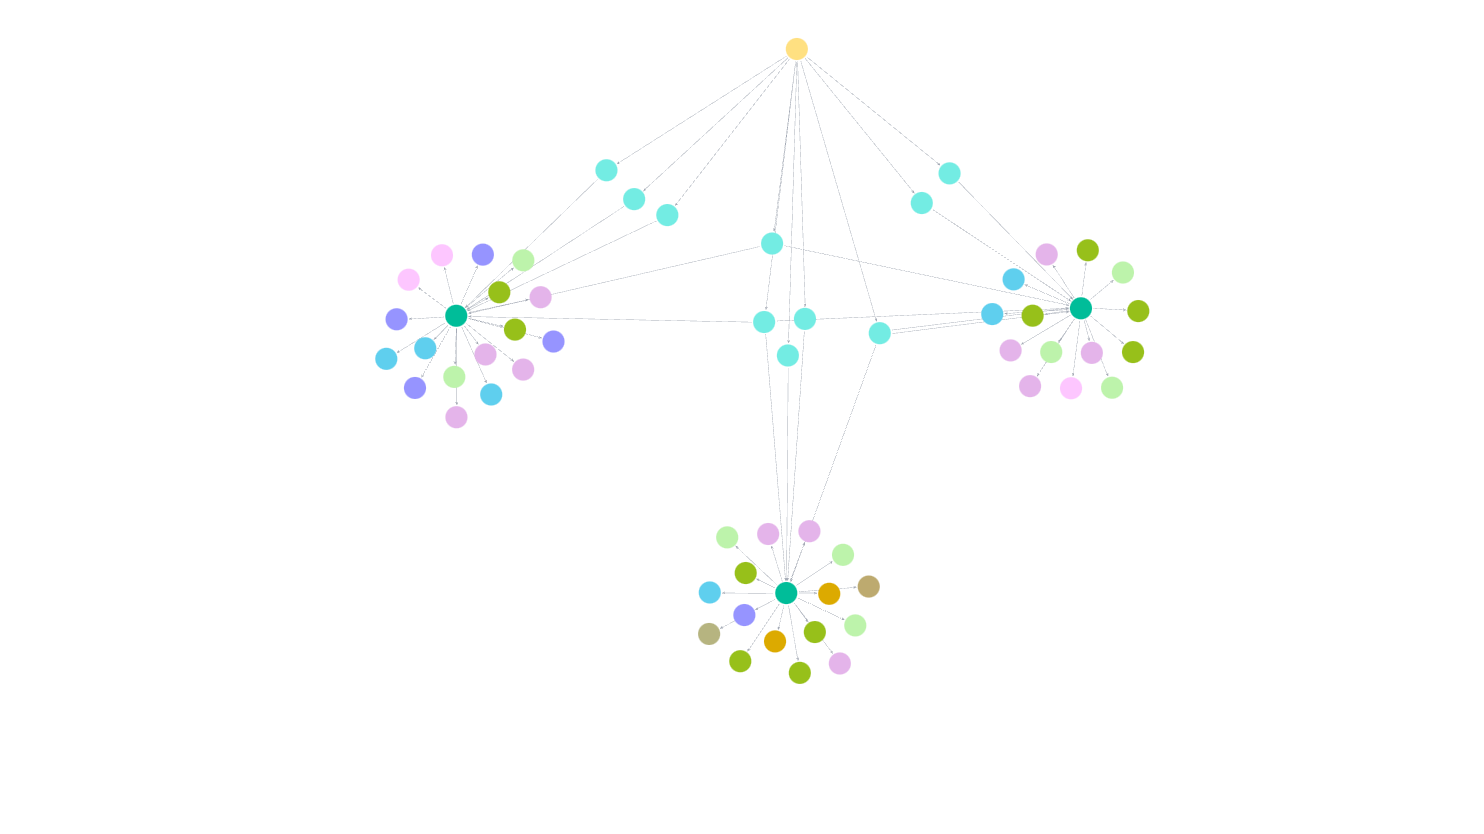

In [50]:
# how to display a png here
from IPython.display import Image
Image("./graph_visualization.png")